In [44]:
import numpy as np
import sympy as sp
from numpy import linalg
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Coin Flips

In [19]:
replication_number = 1000
results = []

for replication in range(replication_number):
    coin_flips = np.random.binomial(10, 0.5, 1000)
    results.append(len(coin_flips[coin_flips == 10]))

results = np.asarray(results)
prob = 1 - (len(results[results == 1]) / replication_number  )
print("Probability is", prob)

Probability is 0.63


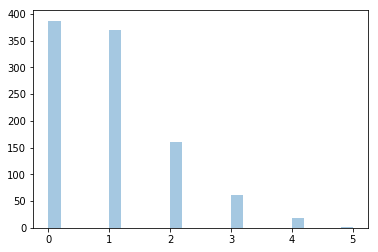

In [21]:
sns.distplot(results, kde=False);

In [22]:
1 -np.exp(-(1000/1024))

0.6233965492891196

### Linear Regression

In [23]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

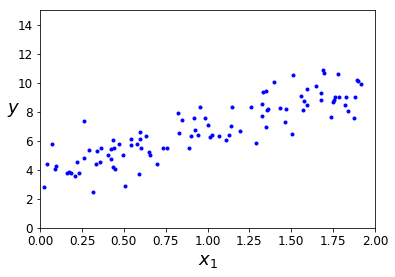

In [26]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [27]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [28]:
theta_best

array([[3.72234578],
       [3.12509553]])

In [29]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.72234578],
       [9.97253685]])

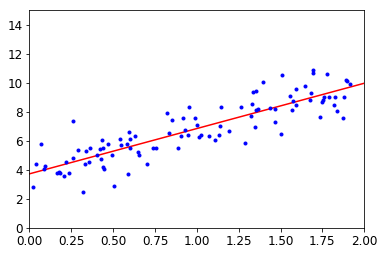

In [30]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [33]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.72234578]), array([[3.12509553]]))

In [34]:
lin_reg.predict(X_new)

array([[3.72234578],
       [9.97253685]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which you could call directly...

### Gradient Descent

In [36]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [37]:
theta

array([[3.72234578],
       [3.12509553]])

In [38]:
X_new_b.dot(theta)

array([[3.72234578],
       [9.97253685]])

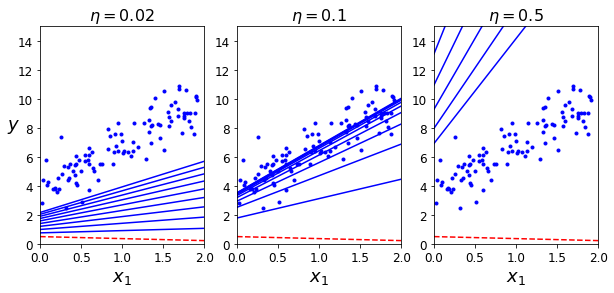

In [40]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

### Backtracking Line Search

In [35]:
alpha = 0.3
beta = 0.8

f = lambda x: (x[0]**2 + 3*x[1]*x[0] + 12)
dfx1 = lambda x: (2*x[0] + 3*x[1])
dfx2 = lambda x: (3*x[0])

t = 1
count = 1
x0 = np.array([2,3])
dx0 = np.array([.1, 0.05])


def backtrack(x0, dfx1, dfx2, t, alpha, beta, count):
    while (f(x0) - (f(x0 - t*np.array([dfx1(x0), dfx2(x0)])) + alpha * t * np.dot(np.array([dfx1(x0), dfx2(x0)]), np.array([dfx1(x0), dfx2(x0)])))) < 0:
        t *= beta
        print("""

########################
###   iteration {}   ###
########################
""".format(count))
        print("Inequality: ",  f(x0) - (f(x0 - t*np.array([dfx1(x0), dfx2(x0)])) + alpha * t * np.dot(np.array([dfx1(x0), dfx2(x0)]), np.array([dfx1(x0), dfx2(x0)]))))
        count += 1
    return t

t = backtrack(x0, dfx1, dfx2, t, alpha, beta,count)

print("\nfinal step size :",  t)



########################
###   iteration 1   ###
########################

Inequality:  -143.12


########################
###   iteration 2   ###
########################

Inequality:  -73.22880000000006


########################
###   iteration 3   ###
########################

Inequality:  -32.172032000000044


########################
###   iteration 4   ###
########################

Inequality:  -8.834580480000021


########################
###   iteration 5   ###
########################

Inequality:  3.7502844927999845

final step size : 0.32768000000000014


### Stochastic Gradient Descent

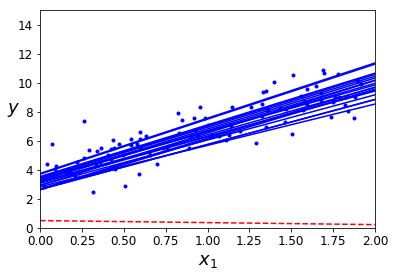

In [42]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)


n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show() 


In [43]:
theta

array([[3.69141228],
       [3.14241768]])

In [45]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [46]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.70736266]), array([3.1053039]))